### An example script to represent the 2-dimensional bin packing problem

In [27]:
!pip3 install ipykernel

In [28]:
!pip3 install networkx matplotlib numpy h5py

In [29]:
!pip3 install torch --index-url https://download.pytorch.org/whl/cu126
!pip3 install torch_geometric

Looking in indexes: https://download.pytorch.org/whl/cu126


In [30]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.nn import GINConv, GATv2Conv
from random import shuffle
from matplotlib.patches import Rectangle

In [31]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATv2Conv(hidden_channels * 4, out_channels, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [32]:
class BinPackingGraph:
    def __init__(self, items, container_width):
        self.packing = []
        self.container_width = container_width
        
        self.G_x = nx.Graph()
        self.G_y = nx.Graph()

        self.bottom_left_packing(items)
        
    def bottom_left_packing(self, items):
        sorted_items = sorted(items, key=lambda x: (-x[1], -x[0]))
        x_cursor, y_cursor = 0, 0
        max_row_height = 0
        
        for w, h in sorted_items:
            if x_cursor + w > self.container_width:
                x_cursor = 0
                y_cursor += max_row_height
                max_row_height = 0
            
            self.packing.append((x_cursor, y_cursor, w, h))
            x_cursor += w
            max_row_height = max(max_row_height, h)

    def random_packing(self, items):
        shuffled_items = items.copy()
        shuffle(shuffled_items)
        x_cursor, y_cursor = 0, 0
        max_row_height = 0

        for w, h in shuffled_items:
            if x_cursor + w > self.container_width:
                x_cursor = 0
                y_cursor += max_row_height
                max_row_height = 0
            
            self.packing.append((x_cursor, y_cursor, w, h))
            x_cursor += w
            max_row_height = max(max_row_height, h)
        
    def construct_graphs(self):
        G_x, G_y = self.G_x, self.G_y
        
        for i, (x1, y1, w1, h1) in enumerate(self.packing):
            G_x.add_node(i, pos=(x1, y1), size=(w1, h1))
            G_y.add_node(i, pos=(x1, y1), size=(w1, h1))

            x1_end = x1 + w1
            y1_end = y1 + h1
            
            for j, (x2, y2, w2, h2) in enumerate(self.packing):
                if i == j:
                    continue
                
                x2_end = x2 + w2
                y2_end = y2 + h2

                if not (x1_end <= x2 or x2_end <= x1):
                    G_y.add_edge(i, j)
                
                if not (y1_end <= y2 or y2_end <= y1):
                    G_x.add_edge(i, j)

        return G_x, G_y

    def nx_to_pyg(self):
        edge_index_x = torch.tensor(list(self.G_x.edges), dtype=torch.long).t().contiguous()
        num_nodes = self.G_x.number_of_nodes()
        x_x = torch.tensor([[self.G_x.nodes[i]['pos'][0], self.G_x.nodes[i]['pos'][1], self.G_x.nodes[i]['size'][0], self.G_x.nodes[i]['size'][1]] for i in range(num_nodes)], dtype=torch.float)

        edge_index_y = torch.tensor(list(self.G_y.edges), dtype=torch.long).t().contiguous()
        num_nodes = self.G_y.number_of_nodes()
        x_y = torch.tensor([[self.G_y.nodes[i]['pos'][0], self.G_y.nodes[i]['pos'][1], self.G_y.nodes[i]['size'][0], self.G_y.nodes[i]['size'][1]] for i in range(num_nodes)], dtype=torch.float)

        return Data(x=x_x, edge_index=edge_index_x), Data(x=x_y, edge_index=edge_index_y)

    def plot_packing(self):
        _, ax = plt.subplots(figsize=(12, 6))

        for i, (x, y, w, h) in enumerate(self.packing):
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black', facecolor='lightblue', alpha=0.7)
            ax.add_patch(rect)
            ax.text(x + w / 2, y + h / 2, f'v{i}', fontsize=12, ha='center', va='center', color='black')

        ax.set_xlim(0, max(x + w for x, _, w, _ in self.packing) + 1)
        ax.set_ylim(0, max(y + h for _, y, _, h in self.packing) + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Packed Rectangles")
        ax.set_aspect('equal')

        plt.gca().invert_yaxis()
        plt.show()
        # plt.savefig('packing.png')
        plt.close()

    def plot_graphs(self):
        plt.figure(figsize=(12, 6))
        nx.draw(self.G_x, with_labels=True)
        plt.title("G_x")
        plt.show()
        # plt.savefig('G_x.png')
        plt.close()

        plt.figure(figsize=(12, 6))
        nx.draw(self.G_y, with_labels=True)
        plt.title("G_y")
        plt.show()
        # plt.savefig('G_y.png')
        plt.close()

In [33]:
items = [(3, 2), (5, 3), (2, 4), (4, 2), (3, 3), (6, 2)]
container_width = 10

bp = BinPackingGraph(items, container_width)
G_x, G_y = bp.construct_graphs()

In [34]:
print("Gx:")
print("Nodes:")
for node in G_x.nodes(data=True): print(node)
print("Edges:")
for edge in G_x.edges(): print(edge)

Gx:
Nodes:
(0, {'pos': (0, 0), 'size': (2, 4)})
(1, {'pos': (2, 0), 'size': (5, 3)})
(2, {'pos': (7, 0), 'size': (3, 3)})
(3, {'pos': (0, 4), 'size': (6, 2)})
(4, {'pos': (6, 4), 'size': (4, 2)})
(5, {'pos': (0, 6), 'size': (3, 2)})
Edges:
(0, 1)
(0, 2)
(1, 2)
(3, 4)


In [35]:
print("Gy:")
print("Nodes:")
for node in G_y.nodes(data=True): print(node)
print("edges:")
for edge in G_y.edges(): print(edge)
print()

Gy:
Nodes:
(0, {'pos': (0, 0), 'size': (2, 4)})
(3, {'pos': (0, 4), 'size': (6, 2)})
(5, {'pos': (0, 6), 'size': (3, 2)})
(1, {'pos': (2, 0), 'size': (5, 3)})
(4, {'pos': (6, 4), 'size': (4, 2)})
(2, {'pos': (7, 0), 'size': (3, 3)})
edges:
(0, 3)
(0, 5)
(3, 1)
(3, 5)
(5, 1)
(1, 4)
(4, 2)



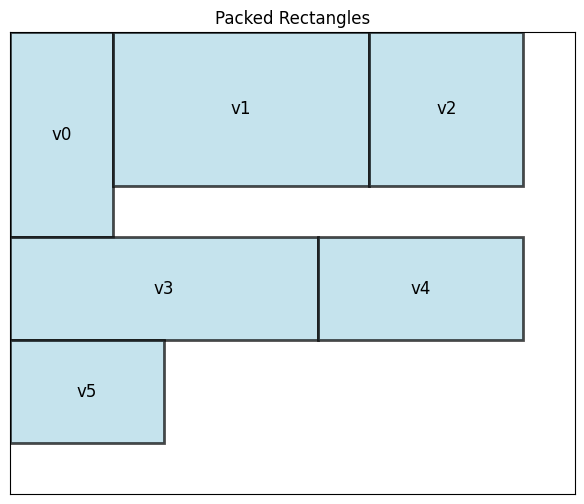

In [36]:

bp.plot_packing()

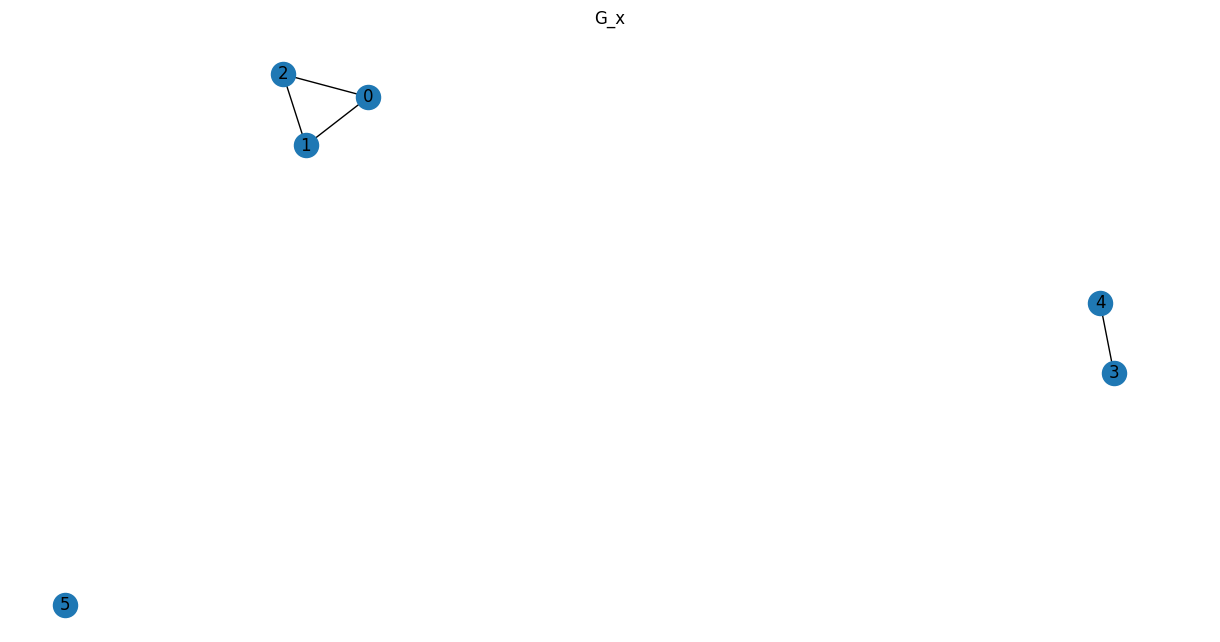

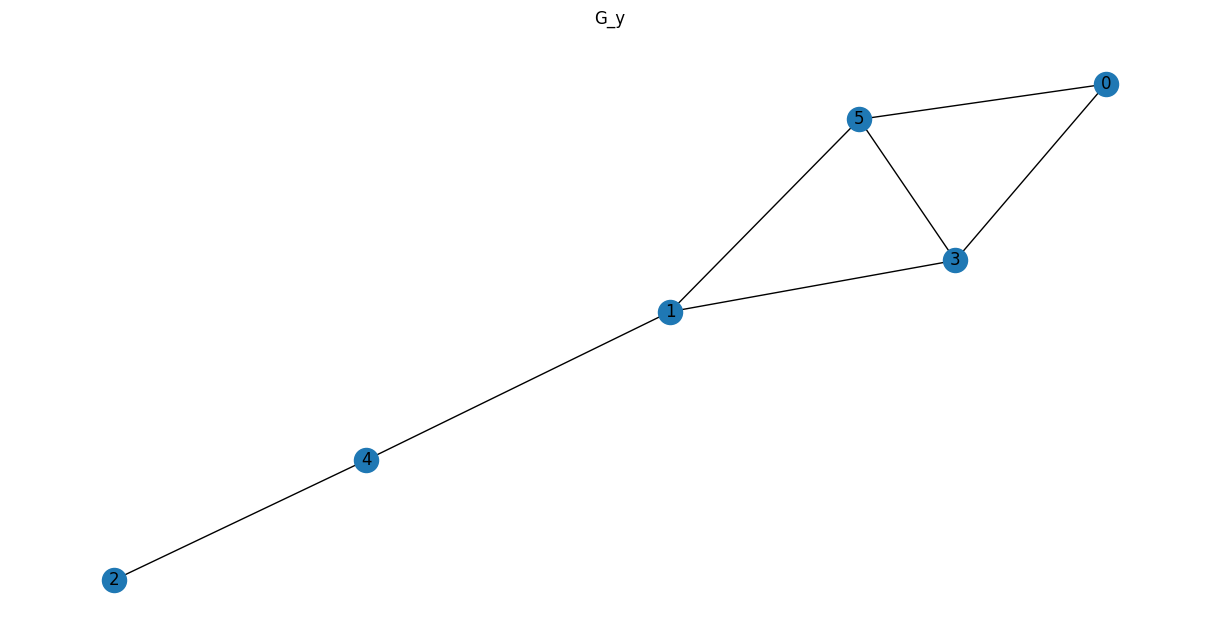

In [37]:
bp.plot_graphs()

In [38]:
data_x, data_y = bp.nx_to_pyg()

data = Data(
    x=data_x.x, 
    edge_index=torch.cat((data_x.edge_index, data_y.edge_index), dim=1)
)   

print("Data:")
print(data.x)
print("Edge Index:")
print(data.edge_index)

Data:
tensor([[0., 0., 2., 4.],
        [2., 0., 5., 3.],
        [7., 0., 3., 3.],
        [0., 4., 6., 2.],
        [6., 4., 4., 2.],
        [0., 6., 3., 2.]])
Edge Index:
tensor([[0, 0, 1, 3, 0, 0, 3, 3, 5, 1, 4],
        [1, 2, 2, 4, 3, 5, 1, 5, 1, 4, 2]])


In [39]:
model = GATEncoder(in_channels=4, hidden_channels=16, out_channels=8)
embeddings = model(data)

print(embeddings)

tensor([[ 0.7384, -0.6513,  0.1183,  0.9314, -0.5140,  0.1068, -0.2902,  0.4435],
        [ 0.3606, -0.2400,  0.1083,  0.6341, -0.8595,  0.6384, -0.8622,  0.0047],
        [ 0.3558, -0.5740, -0.1000,  0.7198, -0.8726,  0.6598, -0.4759,  0.0121],
        [ 0.4595, -0.3127,  0.0770,  0.7283, -0.7277,  0.5283, -0.7484,  0.1921],
        [ 0.1813, -0.2532, -0.0390,  0.6053, -1.0034,  0.8310, -0.8397, -0.1249],
        [ 0.5168, -0.3004,  0.1739,  0.7149, -0.8079,  0.5294, -0.8176,  0.1385]],
       grad_fn=<AddBackward0>)
